# Esperimento loss function: Focal loss

In questo notebook proveremo ad eseguire un training completo utilizzando la **focal loss**.

Questa loss è costruita a partire dalla cross entropy standard e aggiunge un fattore di correzione al fine di dare più importanza agli esempi misclassificati. 

Nel nostro caso la useremo quindi per dare maggior peso nella loss ai pixel appartenenti alle cellule (sottorappresentati e quindi più difficili).

## Configurazione esperimento

Per prima cosa, è utile raggruppare tutti gli iperparametri che influenzano l'addestramento della rete neurale in un unico punto d'accesso, così da rendere più semplici eventuali modifiche.

Allo stesso tempo, è buona prassi tener traccia della configurazione di ogni esperimento per ricostruire quali impostazioni hanno portato a ciascun risultato. Nel nostro caso, il progetto è strutturato con due cartelle di logging:

- *log_path*: vengono registrate tutte le metriche di training
- *model_path*: contiene il modello pre-addestrato migliore prodotto da ciascun esperimento

In [1]:
import sys
from fastai.vision.all import *
from fastai.losses import FocalLossFlat

sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config

# data and augmentation params
BS = 32
CROP_SIZE = 512
RESIZE = 224
MAX_LIGHT = 0.1
ZOOM_DELTA = 0.1  # min_zoom = 1 - ZOOM_DELTA; max_zoom = 1 + ZOOM_DELTA
MAX_ROTATION_ANGLE = 15.0

# model params
N_IN, N_OUT = 16, 2

# optimizer params
# W_CELL, W_BKGD = 1, 1
LOSS_FUNC, LOSS_NAME = FocalLossFlat(axis=1, gamma=2.0, weight=None, reduction='mean'), 'Focal'
LR = None
OPT, OPT_NAME = partial(Adam, lr=LR), 'Adam'
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0, 20 # early stopping
FACTOR, PATIENCE_LR = 1.2, 4 # scheduling learning rate


hyperparameter_defaults = dict(
    bs=BS,
    crop_size=CROP_SIZE,
    resize=RESIZE,
    batch_size=BS,
    angle=MAX_ROTATION_ANGLE,
    zoom_delta=ZOOM_DELTA,
    max_light=MAX_LIGHT,
    # model
    n_in=N_IN, n_out=N_OUT,
    # optimizer
    loss_func=LOSS_FUNC, loss_name=LOSS_NAME,
    lr=LR,
    opt=OPT, opt_name=OPT_NAME,
    monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES},
    lr_monit_dict={'factor': FACTOR, 'patience': PATIENCE_LR},
)

cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

EXP_NAME = f'{LOSS_NAME}'
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
log_path.mkdir(exist_ok=True, parents=True)

model_path = f'{log_path.parent.parent}/models/{EXP_NAME}'

# save config
write_config(hyperparameter_defaults, log_path / "cfg.pkl")
# loaded_cfg = load_config(log_path / "cfg.pkl")

##  Dataloader


/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


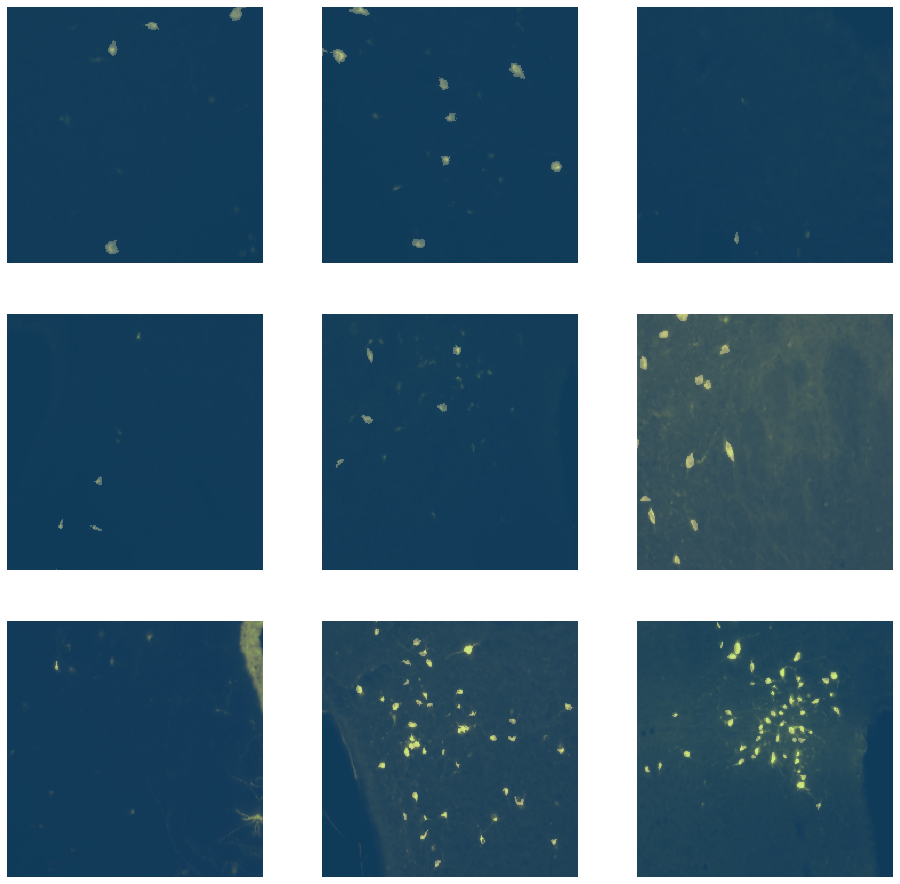

In [2]:
data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
    RandomCrop(CROP_SIZE),
    *aug_transforms(
        size=RESIZE, # resize
        max_lighting=MAX_LIGHT, p_lighting=0.5, # variazione luminosità
        min_zoom=1-ZOOM_DELTA, max_zoom=1+ZOOM_DELTA, # zoom
        max_warp=0, # distorsione
        max_rotate=MAX_ROTATION_ANGLE # rotazione
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cuda'
)

dls.show_batch(max_n=9, figsize=(16,16))

## Learner

In [3]:
from blocks import cResUnet

model = cResUnet(cfg.n_in, cfg.n_out)

CBS = [
#     ReduceLROnPlateau(monitor=MONIT_SCORE,
#                       patience=PATIENCE_LR, factor=FACTOR),
#     EarlyStoppingCallback(monitor=MONIT_SCORE,
#                           min_delta=MIN_DELTA, patience=PATIENCE_ES),
#     SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
#                       every_epoch=False, at_end=False, with_opt=False, reset_on_fit=False),
    CSVLogger()
]


learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/Focal
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/Focal


cResUnet (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     32 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     32 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

SuggestedLRs(valley=0.001737800776027143)

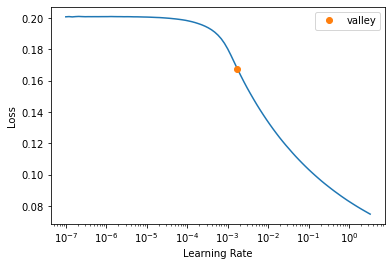

In [4]:
res = learn.lr_find()
res

### Addestramento 

In [5]:
cfg._replace(lr=res.valley)
cfg._replace(opt=partial(Adam, lr=cfg.lr))
write_config(hyperparameter_defaults, log_path / "cfg.pkl")

learn.fit_one_cycle(n_epoch=100, lr_max=res.valley, cbs=CBS)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.196132,0.195172,0.010749,0.005403,1.000000,00:10
1,0.190557,0.194183,0.010749,0.005403,1.000000,00:10
2,0.184410,0.192611,0.010749,0.005403,1.000000,00:10
3,0.176684,0.189473,0.010749,0.005403,1.000000,00:10
4,0.165913,0.184548,0.010652,0.005354,0.983446,00:11
5,0.150480,0.177434,0.010109,0.005080,0.718311,00:11
6,0.130860,0.157767,0.009655,0.004851,0.028723,00:13
7,0.112327,0.133721,0.001144,0.000572,0.000623,00:10
8,0.097586,0.064196,0.001549,0.000775,0.000790,00:14
9,0.086018,0.036782,0.000000,0.000000,0.000000,00:12


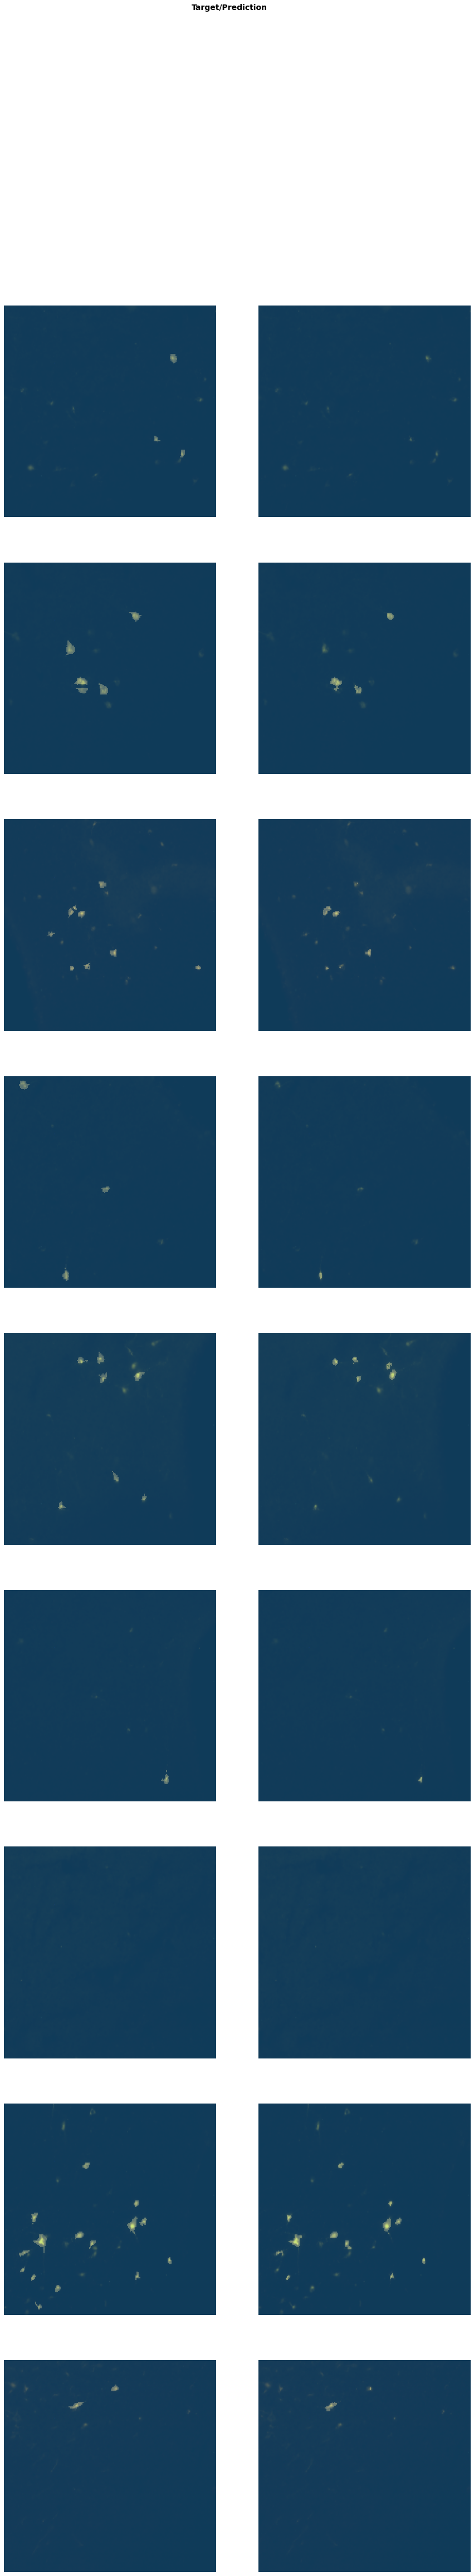

In [6]:
learn.show_results(figsize=(15, 75))

Dopo le prime 10 epoche, l'addestramento inizilamente rimane impantanato in un minimo locale.

A partire dall'**epoca 61** si cominciano a notare dei leggeri ma costanti miglioramenti in termini delle metriche riportate.

In [7]:
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0.005, 20
cfg._replace(monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES})

CBS = [
    SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
                      every_epoch=False, at_end=False, with_opt=True, reset_on_fit=False),
    CSVLogger(append=True)
]

learn.fit_one_cycle(n_epoch=100, lr_max=cfg.lr, cbs=CBS)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.024323,0.024390,0.571233,0.399808,0.426346,00:09
1,0.024360,0.024382,0.572087,0.400646,0.426437,00:10
2,0.024373,0.024319,0.595732,0.424230,0.454872,00:10
3,0.024354,0.024249,0.621726,0.451090,0.487893,00:09
4,0.024361,0.024241,0.624264,0.453767,0.491342,00:09
5,0.024363,0.024202,0.641990,0.472743,0.517544,00:10
6,0.024354,0.024220,0.633505,0.463598,0.503145,00:11
7,0.024365,0.024235,0.622694,0.452110,0.486159,00:11
8,0.024354,0.024175,0.650252,0.481758,0.526882,00:10
9,0.024356,0.024147,0.655883,0.487966,0.533826,00:10


Better model found at epoch 0 with dice value: 0.5712326754493364.
Better model found at epoch 2 with dice value: 0.5957324657927471.
Better model found at epoch 3 with dice value: 0.6217259827866946.
Better model found at epoch 5 with dice value: 0.6419898513954331.
Better model found at epoch 8 with dice value: 0.6502520705797623.
Better model found at epoch 9 with dice value: 0.6558831436508648.
Better model found at epoch 12 with dice value: 0.7121586048042119.
Better model found at epoch 15 with dice value: 0.724542323025119.
Better model found at epoch 16 with dice value: 0.7400954473145974.
Better model found at epoch 27 with dice value: 0.7485712093897434.
Better model found at epoch 41 with dice value: 0.7578505636758064.


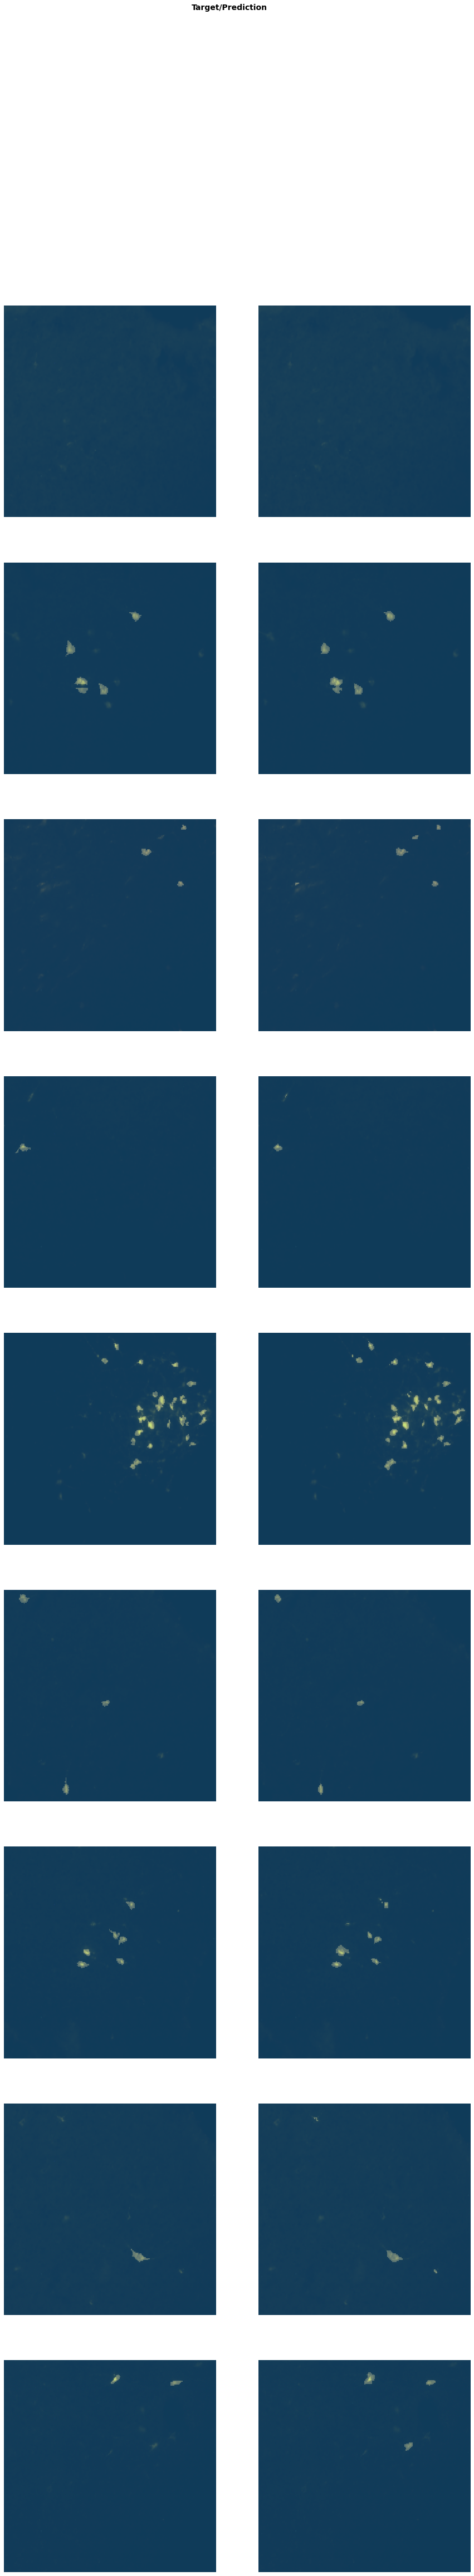

In [8]:
learn.show_results(figsize=(15, 75))

Al termine delle 100 epoche aggiuntive, il modello raggiunge un **dice score attorno al 76%**, con un'**accuratezza del 77%** per i pixel delle cellule.

Guardando poi le maschere predette, notiamo come 

- gli oggetti riconosciuti ricalcano bene gli oggetti realmente presenti
- qualche incertezza è presente negli oggetti più piccoli, con una tendenza a overprediction
- oggetti vicini vengono spesso accorpati insieme